In [92]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# set font size to 12
plt.rcParams.update({'font.size': 13})

In [93]:
# read phases from file
tess_phases = np.loadtxt("../data/tess_phases.txt")
cheops_phases = np.loadtxt("../data/cheops_phases.txt")
flares = pd.read_csv("../results/flare_phases_and_energies.csv")
flares = flares.sort_values("ed_rec", ascending=True).iloc[1:] # exclude the smallest flare

# weigh by observing cadence
weights = np.concatenate([np.ones_like(cheops_phases) * 10. / 60. / 60. / 24., np.ones_like(tess_phases) * 2. / 60. / 24.] )
obs_phases = np.concatenate([cheops_phases, tess_phases])

# flare phases
phases = flares.phase.values

# shift by 0.5
obs_phases = (obs_phases + 0.5) % 1
phases = (phases + 0.5) % 1

# define binning
nbins = 100
bins = np.linspace(0, 1, nbins)
binmids= (bins[1:] + bins[:-1]) / 2

# assign bin number to each observed phase
arr = np.digitize(obs_phases, bins)

# sum the observing times in each bin to binned weights
# unit of entries in binned is [days]
binned = np.array([np.sum(weights[arr==i]) for i in range(1, len(bins))]) 

# observed numbers of flares per time bin
hist, bins = np.histogram(phases, bins=bins)

chainmod = pd.read_csv('../results/modulated_samples.csv')
chainunmod = pd.read_csv('../results/unmodulated_samples.csv')

bestfit = pd.read_csv(f"../results/bestfit_parameters.csv")

bestfit

,Unnamed: 0,lambda0,lambda1,phi0,dphi,lambda0_unmod
0,16th,0.047328,0.294260,0.295961,0.090919,0.158677
1,50th,0.099474,0.533358,0.485139,0.244206,0.207337
2,84th,0.180342,1.004699,0.519058,0.590934,0.266573


In [94]:


# Poisson statistics ---------------------------------------------------------
# define the two models we want to compare

# modulated model
def modulated_model(binmids, lambda0, lambda1, phase0, dphase, weight=binned):

    # make a mask for the elevated flare rate
    mask = (binmids > phase0) & (binmids < (phase0 + dphase)%1)

    # initialize the rate values with zeros
    result = np.zeros_like(binmids)

    # multiply by weight to get lambda_0*t_i and lambda_1*t_i
    result[~mask] = lambda0 * weight[~mask]
    result[mask] = lambda1 * weight[mask]

    return result # rate of observed flares per bin

# unmodulated model
def unmodulated_model(lambda0, weight=binned):
    return lambda0 * weight # rate of observed flares per bin

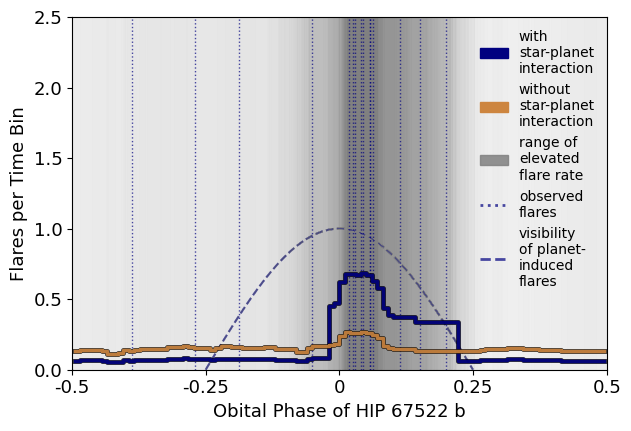

In [164]:
plt.figure(figsize=(6.5, 4.5))

# plot the observed flares as vertical lines at their respective phases
for phase in phases:
    plt.axvline(phase - 0.5, color='navy', alpha=0.7, lw=1, zorder=-500, linestyle=':')


    

# sample from the modulated chain and plot a 100 models
for i in range(150):
    sample = chainmod.sample(n=1)

    # fill between vertical lines  between phi0 and phi0+dphi
    vals = [sample.phi0.values[0]-0.5, (sample.phi0.values[0] + sample.dphi.values[0])-0.5]
    
    plt.fill_between(x=vals, y1=4,
                      color='grey', alpha=0.008, zorder=-1000)
    
    if vals[1] > 0.5:
        vals = [-.5, vals[1] - 1]
        plt.fill_between(x=vals, y1=4,
                      color='grey', alpha=0.008, zorder=-1000)
    elif vals[0] < -0.5:
        vals = [vals[0] + 1, 0.5]
        plt.fill_between(x=vals, y1=4,
                      color='grey', alpha=0.008, zorder=-1000)
    
    
# plot the best fit model for the modulated model
plt.step(binmids -0.5, y=modulated_model(binmids, bestfit.lambda0.values[1],
                                        bestfit.lambda1.values[1], bestfit.phi0.values[1],
                                        bestfit.dphi.values[1]), color='k', lw=3.5, label='best fit modulated', alpha=0.8)
plt.step(binmids -0.5, y=modulated_model(binmids, bestfit.lambda0.values[1],
                                        bestfit.lambda1.values[1], bestfit.phi0.values[1],
                                        bestfit.dphi.values[1]), color='navy', lw=2.5, label='best fit modulated', alpha=0.9)

# plot the best fit model for the unmodulated model

plt.step(binmids -0.5, y=unmodulated_model(bestfit.lambda0_unmod.values[1]), color='k', lw=3.5, alpha=0.8, label='best fit unmodulated')
plt.step(binmids -0.5, y=unmodulated_model(bestfit.lambda0_unmod.values[1]), color='peru', lw=2.5, alpha=0.9, label='best fit unmodulated')

# add a cosine curve to show the phase of the planet
x = np.linspace(-0.25, 0.25, 100)
y = np.cos(2 * np.pi * x)

plt.plot(x, y, c="navy", zorder=-3000, linestyle='--', lw=1.5, alpha=0.7)   

plt.xlim(-.5, .5)
plt.ylim(0, 2.5)
plt.xlabel('Obital Phase of HIP 67522 b')
plt.ylabel('Flares per Time Bin')

# make legend handles
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color='navy', alpha=1, label='with\nstar-planet\ninteraction'),
           mpatches.Patch(color='peru', alpha=1, label='without\nstar-planet\ninteraction'),
           mpatches.Patch(color='grey', alpha=0.85, label='range of\nelevated\nflare rate'),]
                #  mpatches.Patch(color='olive', alpha=1, label='visibility\nof planet-\ninduced\nflares'),]

# add  obsrved flare handle as black dotted line
from matplotlib.lines import Line2D
handles.append(Line2D([0], [0], color='navy', lw=2, linestyle=':', alpha=0.7, label='observed\nflares'))
handles.append(Line2D([0], [0], color='navy', lw=2, linestyle='--', alpha=0.7, label='visibility\nof planet-\ninduced\nflares'))


# replace x-tick labels with -.5, -0.25, 0, 0.25, 0.5
plt.xticks([-0.5, -0.25, 0, 0.25, 0.5], ['-0.5', '-0.25', '0', '0.25', '0.5'])

plt.legend(handles=handles, loc='upper right', frameon=False, fontsize=10)
plt.tight_layout()
plt.savefig('../plots/paper/mcmc.png', dpi=300)

Best-fit models with (dark blue) and without (orange) planet induced flaring in comparison. The light blue shade indicates at which orbital phases an elevated flare rate can be expected based on the observations (dotted lines). The darker the shade, the more likely flaring is elevated at that orbital phase. The observer's sensitivity to detecting planet-induced flares at the sub-planetary point (olive shade) at different orbital phases is consistent with the measured phases of elevated flaring.